In [1]:
import mplfinance as mpf

import core.config as core_config
import analyze.chan as chan
import draw.draw as draw

config = core_config.config

In [2]:
symbol = 'BTCUSDT'
interval = '1d'
df = chan.get_data(symbol, chan.interval_period[interval], config['mahakala']['analyze_amount'])
df = df[:-1]
df = chan.process_data(df)

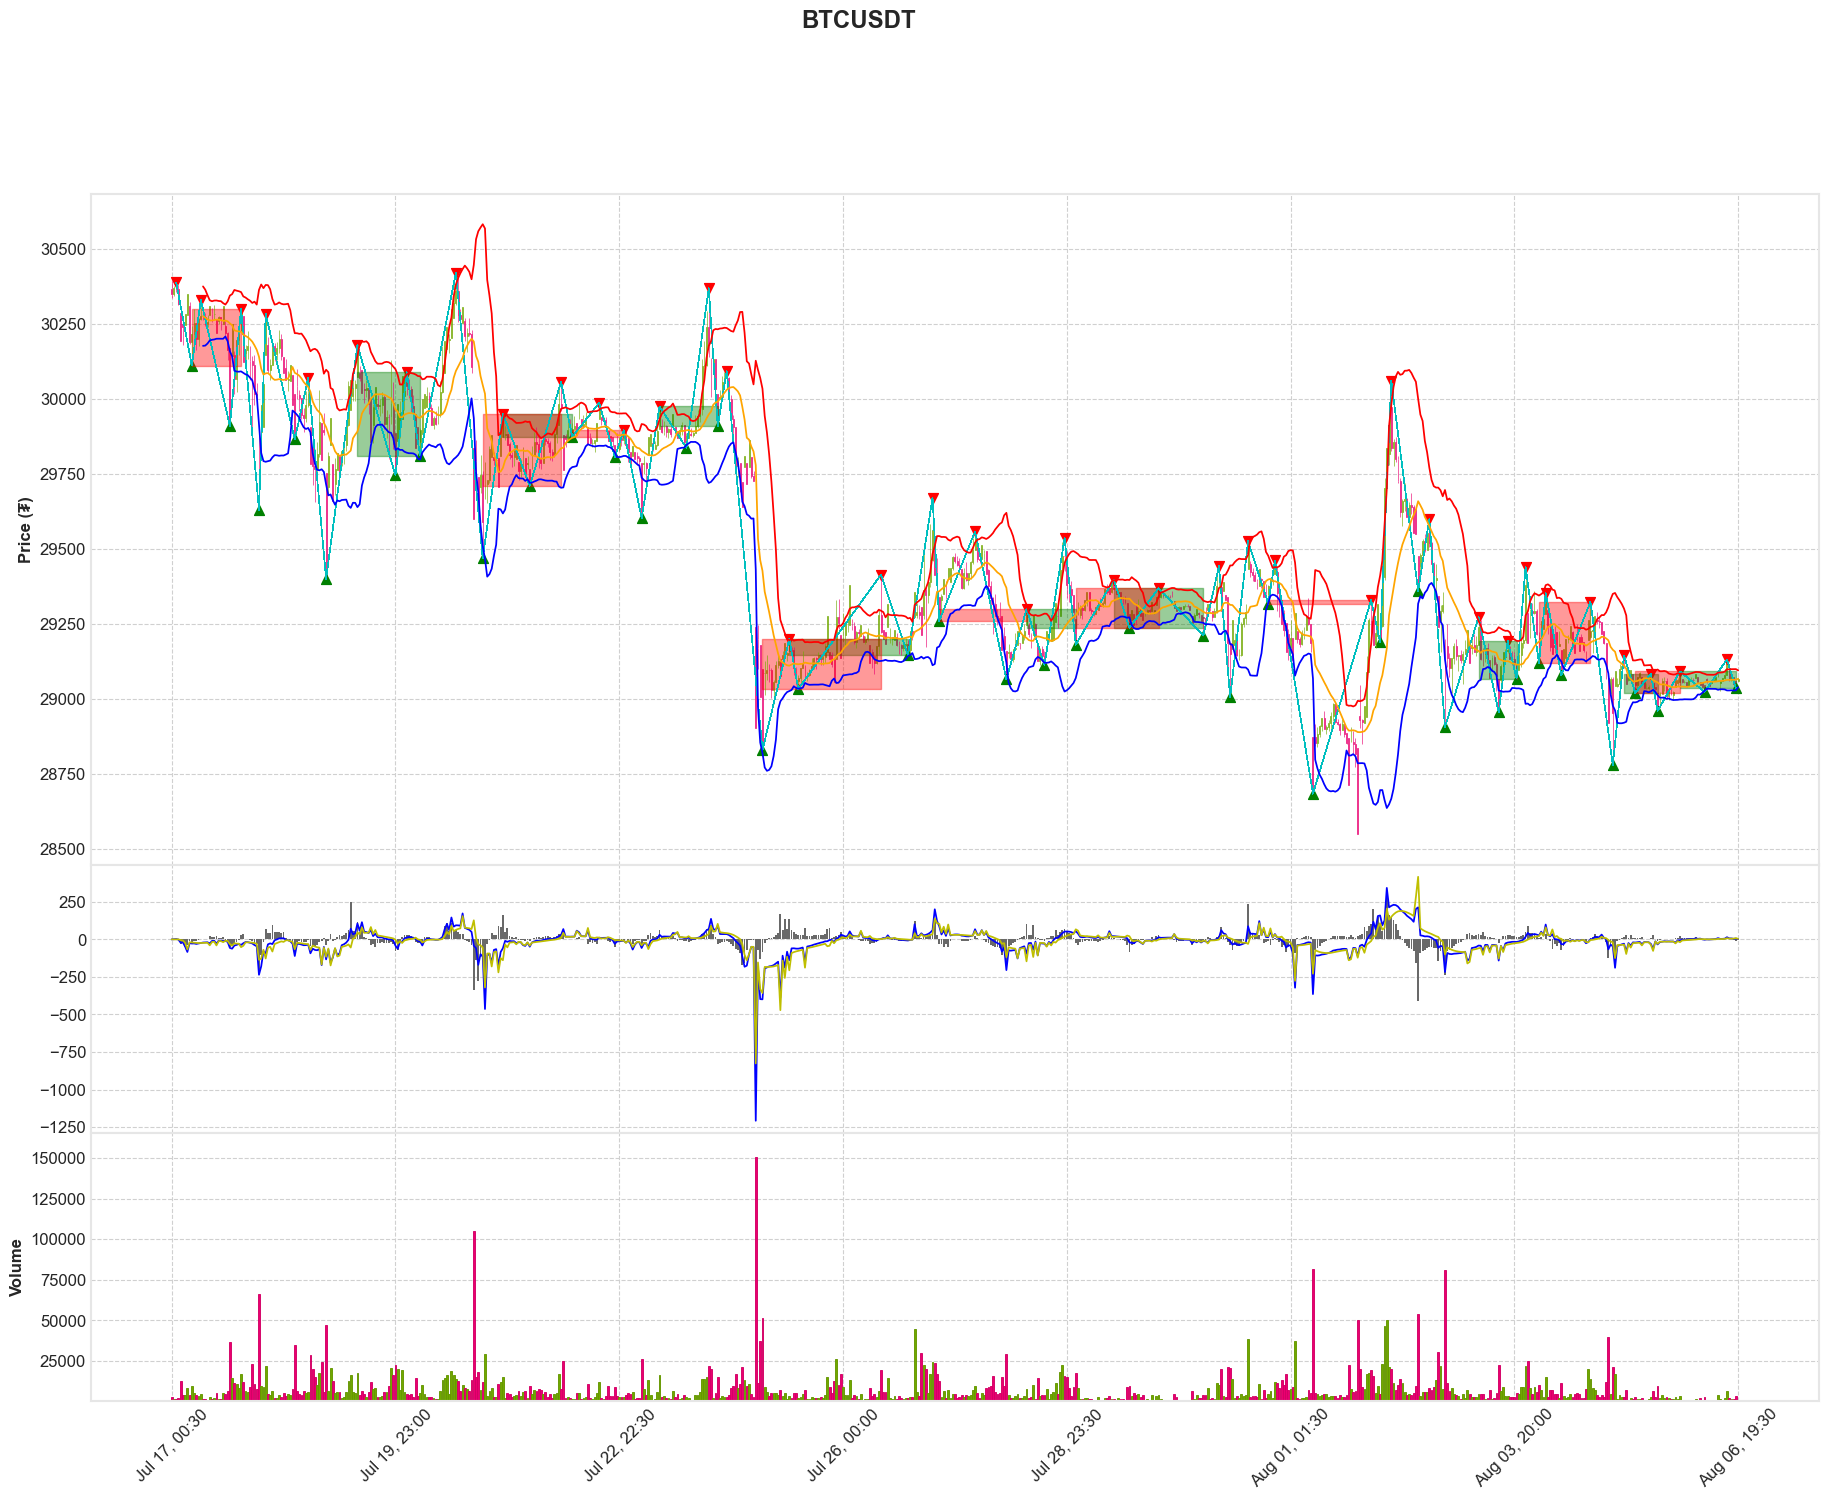

In [4]:
addplot_all = draw.add_plots(df)
all_lines = draw.add_lines(df)
rectangles = draw.add_rectangles(df)
fig_scale = config['mahakala']['analyze_amount'] / 100
# 绘制图表
if len(rectangles) > 0:
    mpf.plot(df, figscale=fig_scale, type='candle', style='binance', title=symbol, ylabel='Price (₮)', volume=True, ylabel_lower='Volume', volume_panel=2, addplot=addplot_all, alines=all_lines, fill_between=rectangles, warn_too_much_data=1000)
else:
    mpf.plot(df, figscale=fig_scale, type='candle', style='binance', title=symbol, ylabel='Price (₮)', volume=True, ylabel_lower='Volume', volume_panel=2, addplot=addplot_all, alines=all_lines, warn_too_much_data=1000)